# 基本信息
1. 实验名称：网络优化
2. 姓名：龙硕
3. 学号：21281165
4. 日期：12.3

# 一、任务1

## 1.1 在多分类任务实验中分别手动实现和用torch.nn实现dropout

1. 探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）



---

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn.functional import cross_entropy, binary_cross_entropy
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from sklearn import  metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 如果有gpu则在gpu上计算 加快计算速度
print(f'当前使用的device为{device}')
# 数据集定义
# 定义多分类数据集 - train_dataloader - test_dataloader
batch_size = 128
# Build the training and testing dataset
traindataset = torchvision.datasets.FashionMNIST(root='Datasets\\FashionMNIST',
                                                  train=True,
                                                  download=True,
                                                  transform=transforms.ToTensor())
testdataset = torchvision.datasets.FashionMNIST(root='Datasets\\FashionMNIST',
                                                 train=False,
                                                 download=True,
                                                 transform=transforms.ToTensor())
traindataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False)  
# 绘制图像的代码
def picture(name, trainl, testl,xlabel='Epoch',ylabel='Loss'):
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    plt.figure(figsize=(8, 3))
    plt.title(name[-1]) # 命名
    color = ['g','r','b','c']
    if trainl is not None:
        plt.subplot(121)
        for i in range(len(name)-1):
            plt.plot(trainl[i], c=color[i],label=name[i])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
    if testl is not None:
        plt.subplot(122)
        for i in range(len(name)-1):
            plt.plot(testl[i], c=color[i], label=name[i])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
print(f'多分类数据集 样本总数量{len(traindataset) + len(testdataset)},训练样本数量{len(traindataset)},测试样本数量{len(testdataset)}')


当前使用的device为cuda
多分类数据集 样本总数量70000,训练样本数量60000,测试样本数量10000


### 手动实现

In [2]:
# 手动实现前馈神经网络代码
from torch.nn import CrossEntropyLoss
from torch.optim import SGD


# dropout = 0.2
class MyNet():
    def __init__(self, dropout=0.0):
        # 设置隐藏层和输出层的节点数
        # global dropout
        self.dropout = dropout
        print('dropout: ', self.dropout)
        self.is_train = None
        num_inputs, num_hiddens, num_outputs = 28 * 28, 256, 10  # 十分类问题
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]
        self.w = [w_1, w_2]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2

    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))

    # 以下两个函数分别在训练和测试前调用，选择是否需要dropout
    def train(self):
        self.is_train = True

    def test(self):
        self.is_train = False

    """
    定义dropout层
    x: 输入数据
    dropout: 随机丢弃的概率
    """

    def dropout_layer(self, x):
        dropout = self.dropout
        assert 0 <= dropout <= 1  # dropout值必须在0-1之间
        # dropout==1，所有元素都被丢弃。
        if dropout == 1:
            return torch.zeros_like(x)
            # 在本情况中，所有元素都被保留。
        if dropout == 0:
            return x
        mask = (torch.rand(x.shape) < 1.0 - dropout).float()  # rand()返回一个张量，包含了从区间[0, 1)的均匀分布中抽取的一组随机数
        return mask * x / (1.0 - dropout)
        # 定义前向传播

    def forward(self, x):
        x = self.input_layer(x)
        if self.is_train:  # 如果是训练过程，则需要开启dropout 否则 需要关闭 dropout
            x = self.dropout_layer(x)
        x = self.my_relu(self.hidden_layer(x))
        if self.is_train:
            x = self.dropout_layer(x)
        x = self.output_layer(x)
        return x


# 默认的优化函数为手写的mySGD
def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr * param.grad


# 定义L2范数惩罚项 参数 w 为模型的 w 在本次实验中为[w_1, w_2] batch_size=128
def l2_penalty(w):
    cost = 0
    for i in range(len(w)):
        cost += (w[i] ** 2).sum()
    return cost / batch_size / 2


"""
定义训练函数
model:定义的模型 默认为MyNet(0) 即无dropout的初始网络
epochs:训练总轮数 默认为30
criterion:定义的损失函数，默认为cross_entropy
lr :学习率 默认为0.1
optimizer:定义的优化函数，默认为自己定义的mySGD函数
"""


def train_and_test(model=MyNet(), init_states=None, optimizer=mySGD, epochs=20, lr=0.01, L2=False, lambd=0):
    train_all_loss = []  # 记录训练集上得loss变化
    test_all_loss = []  # 记录测试集上的loss变化
    train_ACC, test_ACC = [], []  # 记录正确的个数
    begintime = time.time()
    # 激活函数为自己定义的mySGD函数
    # criterion = cross_entropy # 损失函数为交叉熵函数
    criterion = CrossEntropyLoss()  # 损失函数
    model.train()  # 表明当前处于训练状态，允许使用dropout
    for epoch in range(epochs):
        train_l, train_acc_num = 0, 0
        for data, labels in traindataloader:
            pred = model.forward(data)
            train_each_loss = criterion(pred, labels)  # 计算每次的损失值
            # 若L2为True则表示需要添加L2范数惩罚项
            if L2 == True:
                train_each_loss += lambd * l2_penalty(model.w)
            train_l += train_each_loss.item()
            train_each_loss.backward()  # 反向传播
            # 若当前states为 None表示 使用的是 默认的优化函数mySGD
            if init_states == None:
                optimizer(model.params, lr, 128)  # 使用小批量随机梯度下降迭代模型参数
            # 否则的话使用的是自己定义的优化器，通过传入的参数，来实现优化效果
            else:
                states = init_states(model.params)
                optimizer(model.params, states, lr=lr)
            # 梯度清零
            train_acc_num += (pred.argmax(dim=1) == labels).sum().item()
            for param in model.params:
                param.grad.data.zero_()
            # print(train_each_loss)
        train_all_loss.append(train_l)  # 添加损失值到列表中
        train_ACC.append(train_acc_num / len(traindataset))  # 添加准确率到列表中
        model.test()  # 表明当前处于测试状态，无需使用dropout
        with torch.no_grad():
            is_train = False  # 表明当前为测试阶段，不需要dropout参与
            test_l, test_acc_num = 0, 0
            for data, labels in testdataloader:
                pred = model.forward(data)
                test_each_loss = criterion(pred, labels)
                test_l += test_each_loss.item()
                test_acc_num += (pred.argmax(dim=1) == labels).sum().item()
            test_all_loss.append(test_l)
            test_ACC.append(test_acc_num / len(testdataset))  # # 添加准确率到列表中
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc: %.2f | test acc: %.2f'
                  % (epoch + 1, train_l, test_l, train_ACC[-1], test_ACC[-1]))
    endtime = time.time()
    print("手动实现dropout = %d, %d轮 总用时: %.3f" % (model.dropout, epochs, endtime - begintime))
    return train_all_loss, test_all_loss, train_ACC, test_ACC


# torch.nn实现
# 利用torch.nn实现前馈神经网络-多分类任务
from collections import OrderedDict
from torch.nn import CrossEntropyLoss
from torch.optim import SGD


# 定义自己的前馈神经网络
class MyNet_NN(nn.Module):
    def __init__(self, dropout=0.0):
        super(MyNet_NN, self).__init__()
        # 设置隐藏层和输出层的节点数
        self.num_inputs, self.num_hiddens, self.num_outputs = 28 * 28, 256, 10  # 十分类问题
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(28 * 28, 256)
        # 根据设置的dropout设置丢失率
        self.drop = nn.Dropout(dropout)
        self.output_layer = nn.Linear(256, 10)
        # 使用relu激活函数
        self.relu = nn.ReLU()

    # 定义前向传播
    def forward(self, x):
        x = self.drop(self.input_layer(x))
        x = self.drop(self.hidden_layer(x))
        x = self.relu(x)
        x = self.output_layer(x)
        return x


# 训练
# 使用默认的参数即： num_inputs=28*28,num_hiddens=256,num_outs=10,act='relu'
model = MyNet_NN()
model = model.to(device)


# 将训练过程定义为一个函数，方便调用
def train_and_test_NN(model=model, epochs=30, lr=0.01, weight_decay=0.0, optimizer=None):
    MyModel = model
    print(MyModel)
    # 优化函数, 默认情况下weight_decay为0 通过更改weight_decay的值可以实现L2正则化。
    # 默认的优化函数为SGD 可以根据参数来修改优化函数
    if optimizer == None:
        optimizer = SGD(MyModel.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = CrossEntropyLoss()  # 损失函数
    criterion = criterion.to(device)
    train_all_loss = []  # 记录训练集上得loss变化
    test_all_loss = []  # 记录测试集上的loss变化
    train_ACC, test_ACC = [], []
    begintime = time.time()
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in traindataloader:
            data, labels = data.to(device), labels.to(device)
            pred = MyModel(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1) == labels).sum()
        train_ACC.append(train_epoch_count / len(traindataset))
        train_all_loss.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            test_loss, test_epoch_count = 0, 0
            for data, labels in testdataloader:
                data, labels = data.to(device), labels.to(device)
                pred = MyModel(data)
                test_each_loss = criterion(pred, labels)
                test_loss += test_each_loss.item()
                test_epoch_count += (pred.argmax(dim=1) == labels).sum()
            test_all_loss.append(test_loss)
            test_ACC.append(test_epoch_count.cpu() / len(testdataset))
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%5f test acc:%.5f:' % (
                epoch + 1, train_all_loss[-1], test_all_loss[-1],
                train_ACC[-1], test_ACC[-1]))
    endtime = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime - begintime))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss, test_all_loss, train_ACC, test_ACC

dropout:  0.0


In [3]:
# 设置dropout = 0  dropout = 0  epoch = 30  lr = 0.01  optimizer = mySGD
model_11 = MyNet(dropout=0.0)
train_all_loss11,test_all_loss11,\
train_ACC11,test_ACC11 \
= train_and_test(model=model_11,epochs=20,lr=0.01)


# 设置dropout = 0.3  epoch = 30  lr = 0.01  optimizer = mySGD
model_12 = MyNet(dropout=0.3)
train_all_loss12,test_all_loss12,\
train_ACC12,test_ACC12 \
= train_and_test(model=model_12,epochs=20,lr=0.01)

# 设置dropout = 0.6  dropout = 0.6  epoch = 30  lr = 0.01  optimizer = mySGD

model_13 = MyNet(dropout=0.6)
train_all_loss13,test_all_loss13,\
train_ACC13,test_ACC13 \
= train_and_test(model=model_13,epochs=20,lr=0.01)

# 设置dropout = 0.9  dropout = 0.9  epoch = 20  lr = 0.01  optimizer = mySGD

model_14 = MyNet(dropout=0.9)
train_all_loss14,test_all_loss14,\
train_ACC14,test_ACC14 \
= train_and_test(model=model_14,epochs=20,lr=0.01)

dropout:  0.0
epoch: 1 | train loss:865.46234 | test loss:100.65578 | train acc: 0.42 | test acc: 0.60
epoch: 2 | train loss:482.68761 | test loss:70.51137 | train acc: 0.65 | test acc: 0.67
epoch: 4 | train loss:337.32764 | test loss:55.49457 | train acc: 0.74 | test acc: 0.75
epoch: 6 | train loss:289.41420 | test loss:48.78391 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:262.15208 | test loss:45.05077 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:245.26110 | test loss:42.49824 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:233.86667 | test loss:40.91284 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:225.85018 | test loss:39.94292 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:219.58007 | test loss:38.96884 | train acc: 0.84 | test acc: 0.82
epoch: 18 | train loss:214.68409 | test loss:38.42133 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:210.35256 | test loss:37.65936 | train acc: 0.84 | test acc: 0.83
手动实现dropout

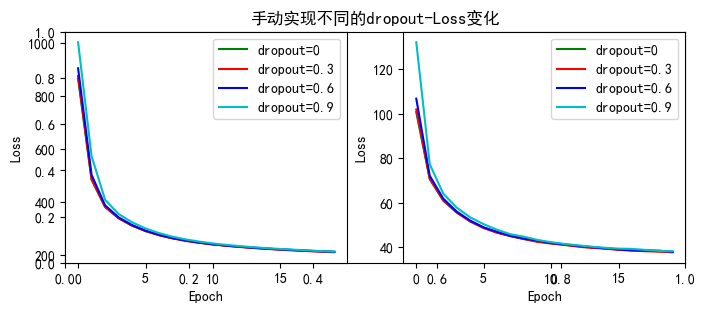

In [4]:
#完成loss的显示
drop_name_1 = ['dropout=0','dropout=0.3','dropout=0.6','dropout=0.9','手动实现不同的dropout-Loss变化']
drop_train_1 = [train_all_loss11,train_all_loss12,train_all_loss13,train_all_loss14]
drop_test_1 = [test_all_loss11,test_all_loss12,test_all_loss13,test_all_loss14]
picture(drop_name_1, drop_train_1, drop_test_1)

### torch.nn实现

In [5]:
# 利用torch.nn 实现
# 利用torch.nn实现前馈神经网络-多分类任务
from collections import OrderedDict
from torch.nn import CrossEntropyLoss
from torch.optim import SGD


# 定义自己的前馈神经网络
class MyNet_NN(nn.Module):
    def __init__(self, dropout=0.0):
        super(MyNet_NN, self).__init__()
        # 设置隐藏层和输出层的节点数
        self.num_inputs, self.num_hiddens, self.num_outputs = 28 * 28, 256, 10  # 十分类问题
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(28 * 28, 256)
        # 根据设置的dropout设置丢失率
        self.drop = nn.Dropout(dropout)
        self.output_layer = nn.Linear(256, 10)
        # 使用relu激活函数
        self.relu = nn.ReLU()

    # 定义前向传播
    def forward(self, x):
        x = self.drop(self.input_layer(x))
        x = self.drop(self.hidden_layer(x))
        x = self.relu(x)
        x = self.output_layer(x)
        return x


# 训练
# 使用默认的参数即： num_inputs=28*28,num_hiddens=256,num_outs=10,act='relu'
model = MyNet_NN()
model = model.to(device)


# 将训练过程定义为一个函数，方便调用
def train_and_test_NN(model=model, epochs=30, lr=0.01, weight_decay=0.0, optimizer=None):
    MyModel = model
    print(MyModel)
    # 优化函数, 默认情况下weight_decay为0 通过更改weight_decay的值可以实现L2正则化。
    # 默认的优化函数为SGD 可以根据参数来修改优化函数
    if optimizer == None:
        optimizer = SGD(MyModel.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = CrossEntropyLoss()  # 损失函数
    criterion = criterion.to(device)
    train_all_loss = []  # 记录训练集上得loss变化
    test_all_loss = []  # 记录测试集上的loss变化
    train_ACC, test_ACC = [], []
    begintime = time.time()
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in traindataloader:
            data, labels = data.to(device), labels.to(device)
            pred = MyModel(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1) == labels).sum()
        train_ACC.append(train_epoch_count / len(traindataset))
        train_all_loss.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            test_loss, test_epoch_count = 0, 0
            for data, labels in testdataloader:
                data, labels = data.to(device), labels.to(device)
                pred = MyModel(data)
                test_each_loss = criterion(pred, labels)
                test_loss += test_each_loss.item()
                test_epoch_count += (pred.argmax(dim=1) == labels).sum()
            test_all_loss.append(test_loss)
            test_ACC.append(test_epoch_count.cpu() / len(testdataset))
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%5f test acc:%.5f:' % (
                epoch + 1, train_all_loss[-1], test_all_loss[-1],
                train_ACC[-1], test_ACC[-1]))
    endtime = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime - begintime))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss, test_all_loss, train_ACC, test_ACC

In [6]:
model_15 = MyNet_NN(dropout=0)
model_15 = model_15.to(device)
train_all_loss15, test_all_loss15, \
train_ACC15, test_ACC15 \
    = train_and_test_NN(model=model_15, epochs=20, lr=0.01)

# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_16 = MyNet_NN(dropout=0.3)
model_16 = model_16.to(device)
train_all_loss16, test_all_loss16, \
train_ACC16, test_ACC16 \
    = train_and_test_NN(model=model_16, epochs=20, lr=0.01)

# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_17 = MyNet_NN(dropout=0.6)
model_17 = model_17.to(device)
train_all_loss17, test_all_loss17, \
train_ACC17, test_ACC17 \
    = train_and_test_NN(model=model_17, epochs=20, lr=0.01)

# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_18 = MyNet_NN(dropout=0.9)
model_18 = model_18.to(device)
train_all_loss18, test_all_loss18, \
train_ACC18, test_ACC18 \
    = train_and_test_NN(model=model_18, epochs=20, lr=0.01)

MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:659.53164 | test loss:74.68901 | train acc:0.617417 test acc:0.67510:
epoch: 2 | train loss:383.28247 | test loss:59.36712 | train acc:0.720300 test acc:0.73270:
epoch: 4 | train loss:292.97379 | test loss:48.81592 | train acc:0.791033 test acc:0.78670:
epoch: 6 | train loss:258.93945 | test loss:44.62085 | train acc:0.815200 test acc:0.80400:
epoch: 8 | train loss:240.78290 | test loss:41.71417 | train acc:0.826700 test acc:0.81590:
epoch: 10 | train loss:229.24360 | test loss:40.36329 | train acc:0.834217 test acc:0.81950:
epoch: 12 | train loss:220.93640 | test loss:39.17665 | train acc:0.838700 test acc:0.82400:
epoch: 14 | train loss:214.60317 | test loss:38.27942 | train acc:0.843517 test acc:0.82770:
epo

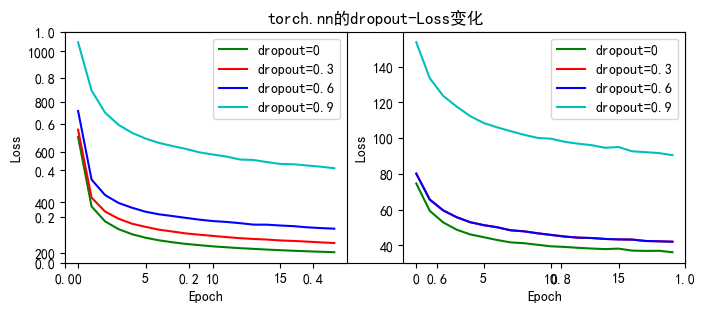

In [7]:
# 完成loss的显示
drop_name_2 = ['dropout=0', 'dropout=0.3', 'dropout=0.6', 'dropout=0.9', 'torch.nn的dropout-Loss变化']
drop_train_2 = [train_all_loss15, train_all_loss16, train_all_loss17, train_all_loss18]
drop_test_2 = [test_all_loss15, test_all_loss16, test_all_loss16, test_all_loss18]
picture(drop_name_2, drop_train_2, drop_test_2)

---

# 二、任务2

## 2.1 在多分类任务实验中分别手动实现和用torch.nn实现𝑳𝟐正则化

1. 探究惩罚项的权重对实验结果的影响（可用loss曲线进行展示)


In [8]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD L2=True lambd=0

model_21 = MyNet(dropout=0)
train_all_loss21,test_all_loss21,\
train_ACC21,test_ACC21\
= train_and_test(model=model_21,epochs=20,lr=0.01,L2=True,lambd=0)


dropout:  0
epoch: 1 | train loss:863.75579 | test loss:100.95440 | train acc: 0.42 | test acc: 0.62
epoch: 2 | train loss:484.34262 | test loss:70.56075 | train acc: 0.65 | test acc: 0.66
epoch: 4 | train loss:339.07920 | test loss:55.65735 | train acc: 0.74 | test acc: 0.75
epoch: 6 | train loss:290.35030 | test loss:48.76206 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:262.17885 | test loss:44.86213 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:245.10980 | test loss:42.71818 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:233.51241 | test loss:40.93063 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:225.34258 | test loss:39.78063 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:218.91126 | test loss:39.00190 | train acc: 0.84 | test acc: 0.82
epoch: 18 | train loss:213.77793 | test loss:38.12329 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:209.79212 | test loss:37.63671 | train acc: 0.85 | test acc: 0.83
手动实现dropout =

In [9]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD L2=True lambd=1

model_22 = MyNet(dropout=0)
train_all_loss22,test_all_loss22,\
train_ACC22,test_ACC22\
= train_and_test(model=model_22,epochs=20,lr=0.01,L2=True,lambd=1)


dropout:  0
epoch: 1 | train loss:902.61986 | test loss:101.57269 | train acc: 0.48 | test acc: 0.61
epoch: 2 | train loss:537.78549 | test loss:71.51162 | train acc: 0.65 | test acc: 0.67
epoch: 4 | train loss:404.55691 | test loss:56.72710 | train acc: 0.74 | test acc: 0.74
epoch: 6 | train loss:362.97774 | test loss:50.31808 | train acc: 0.78 | test acc: 0.78
epoch: 8 | train loss:339.71570 | test loss:46.74585 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:325.77886 | test loss:44.58406 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:316.58699 | test loss:43.40019 | train acc: 0.82 | test acc: 0.81
epoch: 14 | train loss:310.03438 | test loss:42.06926 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:305.15399 | test loss:41.60683 | train acc: 0.83 | test acc: 0.82
epoch: 18 | train loss:301.38522 | test loss:40.74112 | train acc: 0.84 | test acc: 0.82
epoch: 20 | train loss:298.29173 | test loss:40.28003 | train acc: 0.84 | test acc: 0.82
手动实现dropout =

In [10]:
# 设置dropout = 0  dropout = 0  epoch = 30  lr = 0.01  optimizer = SGD weight_decay=0.0

model_24 = MyNet_NN(dropout=0)
model_24 = model_24.to(device)
train_all_loss24,test_all_loss24,\
train_ACC24,test_ACC24 \
= train_and_test_NN(model=model_24,epochs=20,lr=0.01,weight_decay=0.0)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:656.58083 | test loss:74.62385 | train acc:0.623933 test acc:0.67450:
epoch: 2 | train loss:383.17410 | test loss:59.47050 | train acc:0.717300 test acc:0.73470:
epoch: 4 | train loss:293.59943 | test loss:48.89789 | train acc:0.791533 test acc:0.78800:
epoch: 6 | train loss:259.28759 | test loss:44.34013 | train acc:0.815183 test acc:0.80710:
epoch: 8 | train loss:241.04219 | test loss:42.07704 | train acc:0.826683 test acc:0.81530:
epoch: 10 | train loss:229.66759 | test loss:40.63103 | train acc:0.834050 test acc:0.81950:
epoch: 12 | train loss:221.31583 | test loss:39.15298 | train acc:0.838600 test acc:0.82540:
epoch: 14 | train loss:215.34436 | test loss:38.26332 | train acc:0.841683 test acc:0.83000:
epo

In [11]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD weight_decay=1e-3

model_26 = MyNet_NN(dropout=0)
model_26 = model_26.to(device)
train_all_loss26,test_all_loss26,\
train_ACC26,test_ACC26 \
= train_and_test_NN(model=model_26,epochs=20,lr=0.01,weight_decay=1e-3)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:657.07841 | test loss:74.42621 | train acc:0.608167 test acc:0.67370:
epoch: 2 | train loss:383.47098 | test loss:59.56973 | train acc:0.720267 test acc:0.73550:
epoch: 4 | train loss:293.96878 | test loss:48.87507 | train acc:0.790933 test acc:0.78450:
epoch: 6 | train loss:259.91230 | test loss:44.66404 | train acc:0.815533 test acc:0.80270:
epoch: 8 | train loss:242.05550 | test loss:42.37349 | train acc:0.825833 test acc:0.81390:
epoch: 10 | train loss:230.70635 | test loss:40.47909 | train acc:0.832950 test acc:0.82290:
epoch: 12 | train loss:222.79334 | test loss:39.18224 | train acc:0.837833 test acc:0.82550:
epoch: 14 | train loss:216.87930 | test loss:38.76730 | train acc:0.841433 test acc:0.82880:
epo

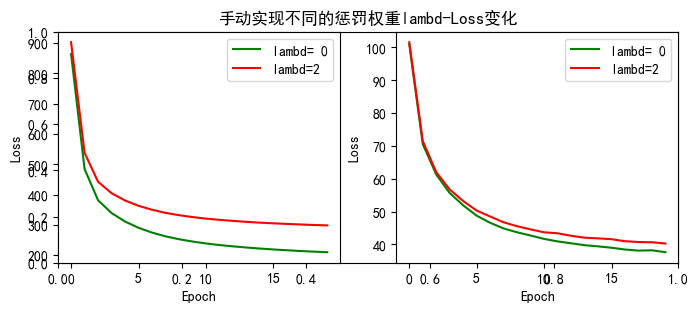

In [12]:
#完成loss的显示
drop_name_3 = ['lambd= 0','lambd=2','手动实现不同的惩罚权重lambd-Loss变化']
drop_train_3 = [train_all_loss21,train_all_loss22]
drop_test_3= [test_all_loss21,test_all_loss22]
picture(drop_name_3, drop_train_3,drop_test_3)


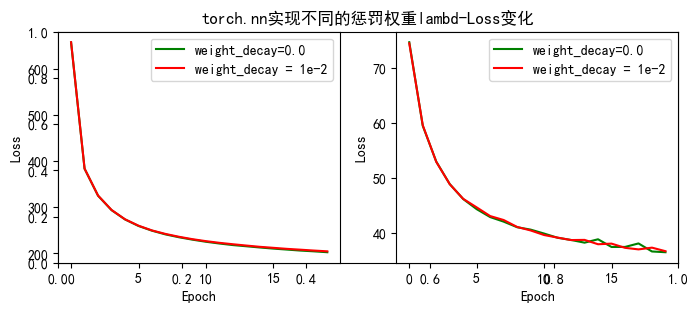

In [13]:
#完成loss的显示
drop_name_4= ['weight_decay=0.0','weight_decay = 1e-2','torch.nn实现不同的惩罚权重lambd-Loss变化']
drop_train_4 = [train_all_loss24,train_all_loss26]
drop_test_4= [test_all_loss24,test_all_loss26]
picture(drop_name_4, drop_train_4,drop_test_4)


In [14]:
# 实验代码
print("Hello World!")

Hello World!


# 三、任务3

## 3.1 在多分类任务实验中实现momentum、rmsprop、adam优化器

1. 在手动实现多分类的任务中手动实现三种优化算法，并补全Adam中计算部分的内容

2. 在torch.nn实现多分类的任务中使用torch.nn实现各种优化器，并对比其效果


In [15]:
# 初始化
def init_rmsprop(params):
    s_w1, s_b1, s_w2, s_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape),\
                             torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    return (s_w1, s_b1, s_w2, s_b2)
# 对每一个参数进行RMSprop法
def rmsprop(params,states,lr=0.01,gamma=0.9):
    gamma, eps = gamma, 1e-6
    for p, s in zip(params,states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= lr * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

model_31 = MyNet(dropout=0)
train_all_loss31,test_all_loss31,\
train_ACC31,test_ACC31 \
= train_and_test(model=model_31,epochs=20,init_states=init_rmsprop,optimizer=rmsprop)


dropout:  0
epoch: 1 | train loss:479.44797 | test loss:68.47234 | train acc: 0.69 | test acc: 0.77
epoch: 2 | train loss:373.08925 | test loss:58.50375 | train acc: 0.77 | test acc: 0.76
epoch: 4 | train loss:342.01890 | test loss:65.07650 | train acc: 0.79 | test acc: 0.77
epoch: 6 | train loss:336.53867 | test loss:72.02951 | train acc: 0.79 | test acc: 0.77
epoch: 8 | train loss:307.91610 | test loss:51.93041 | train acc: 0.81 | test acc: 0.77
epoch: 10 | train loss:300.54314 | test loss:59.12906 | train acc: 0.81 | test acc: 0.80
epoch: 12 | train loss:287.35347 | test loss:58.37638 | train acc: 0.82 | test acc: 0.81
epoch: 14 | train loss:288.79043 | test loss:58.86185 | train acc: 0.82 | test acc: 0.82
epoch: 16 | train loss:277.16197 | test loss:61.27242 | train acc: 0.83 | test acc: 0.82
epoch: 18 | train loss:277.73642 | test loss:59.83096 | train acc: 0.83 | test acc: 0.82
epoch: 20 | train loss:276.31294 | test loss:57.56420 | train acc: 0.83 | test acc: 0.79
手动实现dropout = 

In [16]:
# 初始化
def init_momentum(params):
    v_w1, v_b1, v_w2, v_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape),\
                             torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    return (v_w1, v_b1, v_w2, v_b2)
# 对每一个参数进行momentum法
def sgd_momentum(params,states,lr=0.01,momentum=0.5):
    for p, v in zip(params,states):
        with torch.no_grad():
            v[:] = momentum * v - p.grad
            p[:] += lr * v
        p.grad.data.zero_()

model_32 = MyNet(dropout=0)
train_all_loss32,test_all_loss32,\
train_ACC32,test_ACC32 \
= train_and_test(model=model_32,epochs=20,init_states=init_momentum, optimizer=sgd_momentum)


dropout:  0
epoch: 1 | train loss:862.30024 | test loss:101.17166 | train acc: 0.45 | test acc: 0.61
epoch: 2 | train loss:484.19595 | test loss:70.32166 | train acc: 0.65 | test acc: 0.66
epoch: 4 | train loss:337.76284 | test loss:55.49502 | train acc: 0.74 | test acc: 0.75
epoch: 6 | train loss:288.86636 | test loss:48.53711 | train acc: 0.79 | test acc: 0.79
epoch: 8 | train loss:261.12367 | test loss:44.97400 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:244.19067 | test loss:42.47516 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:232.87323 | test loss:40.83483 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:224.88660 | test loss:39.68375 | train acc: 0.84 | test acc: 0.82
epoch: 16 | train loss:218.73582 | test loss:38.85602 | train acc: 0.84 | test acc: 0.83
epoch: 18 | train loss:213.80782 | test loss:38.08839 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:209.67290 | test loss:37.46450 | train acc: 0.85 | test acc: 0.83
手动实现dropout =

In [17]:
def init_adam_states(params):
    v_w1, v_b1, v_w2, v_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape),\
                             torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    s_w1, s_b1, s_w2, s_b2 = torch.zeros(params[0].shape), torch.zeros(params[1].shape),\
                             torch.zeros(params[2].shape), torch.zeros(params[3].shape)
    return ((v_w1, s_w1), (v_b1, s_b1),(v_w2, s_w2), (v_b2, s_b2))

# 根据Adam算法思想手动实现Adam
Adam_t = 0.01
def Adam(params, states, lr=0.01, t=Adam_t):
    global Adam_t
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * (p.grad**2)
            v_bias_corr = v / (1 - beta1 ** Adam_t)
            s_bias_corr = s / (1 - beta2 ** Adam_t)
        p.data -= lr * v_bias_corr / (torch.sqrt(s_bias_corr + eps))
    p.grad.data.zero_()
    Adam_t += 1
model_33 = MyNet(dropout=0)
train_all_loss33,test_all_loss33,\
train_ACC33,test_ACC33 \
= train_and_test(model=model_33,epochs=20,init_states=init_adam_states, optimizer=Adam)    


dropout:  0
epoch: 1 | train loss:925.31636 | test loss:49.02396 | train acc: 0.72 | test acc: 0.76
epoch: 2 | train loss:223.60388 | test loss:42.08650 | train acc: 0.83 | test acc: 0.82
epoch: 4 | train loss:177.13549 | test loss:37.58962 | train acc: 0.86 | test acc: 0.83
epoch: 6 | train loss:157.29137 | test loss:33.30744 | train acc: 0.88 | test acc: 0.86
epoch: 8 | train loss:145.41839 | test loss:32.62460 | train acc: 0.89 | test acc: 0.86
epoch: 10 | train loss:134.98120 | test loss:37.30796 | train acc: 0.89 | test acc: 0.85
epoch: 12 | train loss:130.01067 | test loss:30.03027 | train acc: 0.90 | test acc: 0.87
epoch: 14 | train loss:122.31213 | test loss:41.12192 | train acc: 0.90 | test acc: 0.84
epoch: 16 | train loss:118.01939 | test loss:32.65074 | train acc: 0.91 | test acc: 0.87
epoch: 18 | train loss:112.73461 | test loss:33.85423 | train acc: 0.91 | test acc: 0.87
epoch: 20 | train loss:106.93697 | test loss:50.44302 | train acc: 0.92 | test acc: 0.82
手动实现dropout = 

In [18]:
# 使用torch 提供的 RMSprop
model_34 = MyNet_NN(dropout=0)
model_34 = model_34.to(device)

opti_RMSprop = torch.optim.RMSprop(model_34.parameters(), lr=0.01, alpha=0.9, eps=1e-6)
train_all_loss34,test_all_loss34,\
train_ACC34,test_ACC34 \
= train_and_test_NN(model=model_34,epochs=20,optimizer=opti_RMSprop)    


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:308.22296 | test loss:37.14341 | train acc:0.779083 test acc:0.81560:
epoch: 2 | train loss:205.80155 | test loss:34.65582 | train acc:0.842583 test acc:0.84540:
epoch: 4 | train loss:181.36134 | test loss:33.33037 | train acc:0.863150 test acc:0.85390:
epoch: 6 | train loss:172.99824 | test loss:33.73866 | train acc:0.873150 test acc:0.85550:
epoch: 8 | train loss:167.40632 | test loss:37.61154 | train acc:0.878300 test acc:0.85420:
epoch: 10 | train loss:156.40885 | test loss:43.03286 | train acc:0.882883 test acc:0.85170:
epoch: 12 | train loss:158.72900 | test loss:41.29741 | train acc:0.883983 test acc:0.84290:
epoch: 14 | train loss:152.26227 | test loss:42.96841 | train acc:0.887950 test acc:0.85710:
epo

In [19]:
# 使用torch 提供的 Momentum
model_35 = MyNet_NN(dropout=0)
model_35 = model_35.to(device)

opt_Momentum = torch.optim.SGD(model_35.parameters(),lr=0.01, momentum=0.5)
train_all_loss35,test_all_loss35,\
train_ACC35,test_ACC35 \
= train_and_test_NN(model=model_35,epochs=20,optimizer=opt_Momentum)    


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:526.47674 | test loss:59.44141 | train acc:0.655800 test acc:0.73260:
epoch: 2 | train loss:309.91542 | test loss:48.93904 | train acc:0.777400 test acc:0.78540:
epoch: 4 | train loss:245.94917 | test loss:41.89833 | train acc:0.822283 test acc:0.81430:
epoch: 6 | train loss:224.64349 | test loss:39.27568 | train acc:0.835883 test acc:0.82510:
epoch: 8 | train loss:212.38218 | test loss:38.29040 | train acc:0.843483 test acc:0.82540:
epoch: 10 | train loss:204.32066 | test loss:36.57679 | train acc:0.850150 test acc:0.83530:
epoch: 12 | train loss:197.81626 | test loss:36.46866 | train acc:0.854933 test acc:0.83500:
epoch: 14 | train loss:192.36287 | test loss:34.64908 | train acc:0.858183 test acc:0.84450:
epo

In [20]:
# 使用torch 提供的 Adam
model_36 = MyNet_NN(dropout=0)
model_36 = model_36.to(device)

opt_Adam = torch.optim.Adam(model_36.parameters(), lr=0.01, betas=(0.9,0.999),eps=1e-6)
train_all_loss36,test_all_loss36,\
train_ACC36,test_ACC36 \
= train_and_test_NN(model=model_36,epochs=20,optimizer=opt_Adam)    


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:234.55397 | test loss:34.81386 | train acc:0.820033 test acc:0.84180:
epoch: 2 | train loss:182.52053 | test loss:32.42178 | train acc:0.857517 test acc:0.85300:
epoch: 4 | train loss:162.96026 | test loss:32.20792 | train acc:0.872517 test acc:0.85580:
epoch: 6 | train loss:150.17036 | test loss:32.20732 | train acc:0.881683 test acc:0.86070:
epoch: 8 | train loss:142.96840 | test loss:31.43630 | train acc:0.887950 test acc:0.86370:
epoch: 10 | train loss:143.71690 | test loss:33.00417 | train acc:0.888000 test acc:0.85090:
epoch: 12 | train loss:136.48682 | test loss:31.20676 | train acc:0.892050 test acc:0.86940:
epoch: 14 | train loss:134.12165 | test loss:31.61501 | train acc:0.892767 test acc:0.87050:
epo

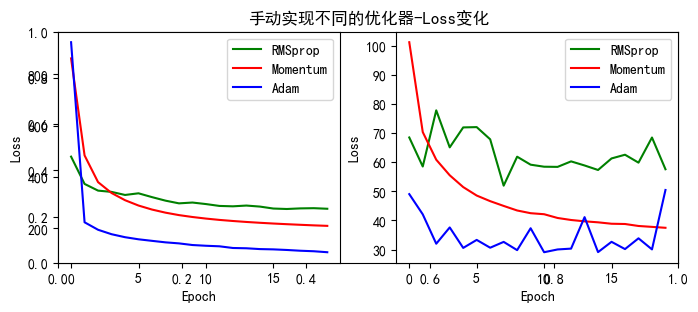

In [21]:
#完成loss的显示
drop_name_5= ['RMSprop','Momentum','Adam','手动实现不同的优化器-Loss变化']
drop_train_5 = [train_all_loss31,train_all_loss32,train_all_loss33]
drop_test_5= [test_all_loss31,test_all_loss32,test_all_loss33]
picture(drop_name_5, drop_train_5,drop_test_5)


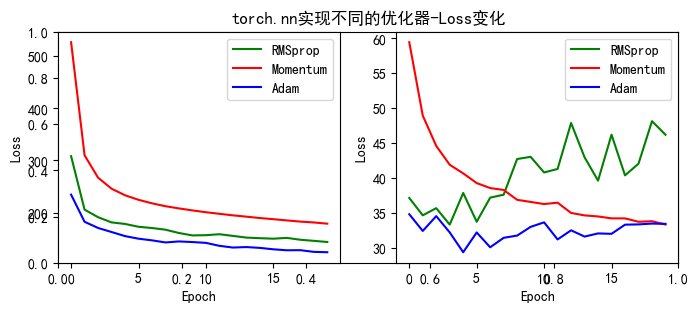

In [22]:
drop_name_6= ['RMSprop','Momentum','Adam','torch.nn实现不同的优化器-Loss变化']
drop_train_6 = [train_all_loss34,train_all_loss35,train_all_loss36]
drop_test_6= [test_all_loss34,test_all_loss35,test_all_loss36]
picture(drop_name_6, drop_train_6,drop_test_6)


In [23]:
# 实验代码
print("Hello World!")

Hello World!


# 四、任务4

## 4.1 对多分类任务实验中实现早停机制，并在测试集上测试


1. 选择上述实验中效果最好的组合，手动将训练数据划分为训练集和验证集，实现早停机制，并在测试集上进行测试。训练集：验证集=8：2，早停轮数为5


In [24]:
import random
# 得到0-60000的下标
index = list(range(len(traindataset)))
# 利用shuffle随机打乱下标
random.shuffle(index)
# 按照 训练集和验证集 8：2 的比例分配各自下标
train_index, val_index = index[ : 48000], index[48000 : ]
# 由分配的下标得到对应的训练和验证及的数据以及他们对应的标签
train_dataset, train_labels = traindataset.data[train_index], traindataset.targets[train_index]
val_dataset, val_labels = traindataset.data[val_index], traindataset.targets[val_index]
print('训练集:', train_dataset.shape, train_labels.shape)
print('验证集:', val_dataset.shape,val_labels.shape)
# 构建相应的dataset以及dataloader
T_dataset = torch.utils.data.TensorDataset(train_dataset,train_labels)
V_dataset = torch.utils.data.TensorDataset(val_dataset,val_labels)
T_dataloader = torch.utils.data.DataLoader(dataset=T_dataset,batch_size=128,shuffle=True)
V_dataloader = torch.utils.data.DataLoader(dataset=V_dataset,batch_size=128,shuffle=True)
print('T_dataset',len(T_dataset),'T_dataloader batch_size: 128')
print('V_dataset',len(V_dataset),'V_dataloader batch_size: 128')


训练集: torch.Size([48000, 28, 28]) torch.Size([48000])
验证集: torch.Size([12000, 28, 28]) torch.Size([12000])
T_dataset 48000 T_dataloader batch_size: 128
V_dataset 12000 V_dataloader batch_size: 128


In [25]:
def train_and_test_4(model=model,epochs=30,lr=0.01,weight_decay=0.0):
    print(model)
     # 优化函数, 默认情况下weight_decay为0 通过更改weight_decay的值可以实现L2正则化。
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.999),eps=1e-6)
    criterion = CrossEntropyLoss() # 损失函数
    train_all_loss = []  # 记录训练集上得loss变化
    val_all_loss = []  # 记录测试集上的loss变化
    train_ACC, val_ACC = [], []
    begintime = time.time()
    flag_stop = 0
    for epoch in range(1000):
        train_l, train_epoch_count, val_epoch_count = 0, 0, 0
        for data, labels in traindataloader:
            data, labels = data.to(torch.float32).to(device), labels.to(device)
            pred = model(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1)==labels).sum()
        train_ACC.append(train_epoch_count/len(traindataset))
        train_all_loss.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            val_loss, val_epoch_count= 0, 0
            for data, labels in testdataloader:
                data, labels = data.to(torch.float32).to(device), labels.to(device)
                pred = model(data)
                val_each_loss = criterion(pred,labels)
                val_loss += val_each_loss.item()
                val_epoch_count += (pred.argmax(dim=1)==labels).sum()
            val_all_loss.append(val_loss)
            val_ACC.append(val_epoch_count / len(testdataset))
             # 实现早停机制
            # 若连续五次验证集的损失值连续增大，则停止运行，否则继续运行，
            if epoch > 5 and val_all_loss[-1] > val_all_loss[-2]:
                flag_stop += 1
                if flag_stop == 5 or epoch > 35:
                    print('停止运行，防止过拟合')
                    break
            else:
                flag_stop = 0
        if epoch == 0 or (epoch + 1) % 4 == 0:
            print('epoch: %d | train loss:%.5f | val loss:%.5f | train acc:%5f val acc:%.5f:' % (epoch + 1, train_all_loss[-1], val_all_loss[-1],
                                                                                                                     train_ACC[-1],val_ACC[-1]))
    endtime = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime - begintime))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss,val_all_loss,train_ACC,val_ACC
model_41 = MyNet_NN(dropout=0.5)
model_41 = model_41.to(device)
train_all_loss41,test_all_loss41,\
train_ACC41,test_ACC41 \
= train_and_test_4(model=model_41,epochs = 10000,lr=0.1)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:356.82107 | val loss:58.91434 | train acc:0.717600 val acc:0.72880:
epoch: 4 | train loss:321.69893 | val loss:57.85853 | train acc:0.750767 val acc:0.74310:
epoch: 8 | train loss:322.04854 | val loss:58.64583 | train acc:0.751883 val acc:0.73890:
epoch: 12 | train loss:312.09493 | val loss:58.71657 | train acc:0.762400 val acc:0.74300:
epoch: 16 | train loss:307.91304 | val loss:58.93676 | train acc:0.765333 val acc:0.75160:
epoch: 20 | train loss:311.26280 | val loss:55.96568 | train acc:0.763233 val acc:0.76250:
epoch: 24 | train loss:308.34014 | val loss:57.71276 | train acc:0.763533 val acc:0.74420:
epoch: 28 | train loss:314.38591 | val loss:57.47082 | train acc:0.761267 val acc:0.74270:
epoch: 32 | tra

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


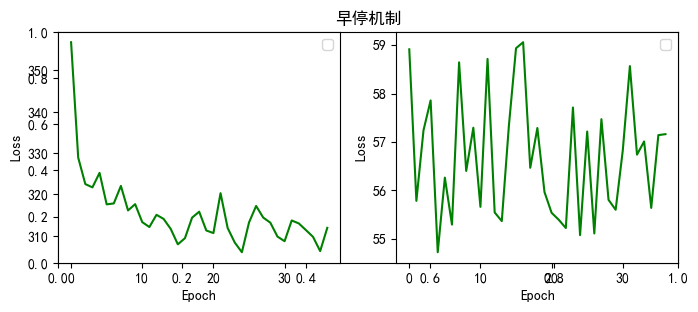

In [26]:
#完成loss的显示
drop_name_6= ['','早停机制']
drop_train_6 = [train_all_loss41]
drop_test_6= [test_all_loss41]
picture(drop_name_6, drop_train_6,drop_test_6)


In [27]:
# 实验代码
print("Hello World!")

Hello World!


---